# Simple logistic model with uncertainty
We want
- Logistic regression 
- LASSO/Ridge regularization
- Uncertainty quantification and prior-ification

## Model
Let $Y_{it}$ be the Republican _score_, defined as the proportion of votes Republican received over the total votes received by Republican and Democratic candidates. Let $W_{it}$ be whether the Republican wins.

Assume that 
$$
Y_{it} \sim \mathcal{N}(X\beta, \sigma^2)
$$
We infer $\beta$ via a penalized logistic regression with cross-validation selection of the penalities. We infer $\sigma^2$ by simply taking the variance of the prediction errors.

On the test set, assume that polls are drawn from $\text{Bin}(n, Y) \approx \mathcal{N}(nY, nY(1-Y))$. This is a normal likelihood with normal prior Bayesian model, and the posterior is easy to compute.

In [1]:
import glmnet_python
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

In [2]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

In [3]:
train = pd.read_feather('data/cleaned_train_Kevin.feather')

/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [4]:
state = pd.get_dummies(train['state']).iloc[:,:-1]

In [5]:
train['approvalxdem'] = train['pres_approval'] * train['same_as_pres_party_dem']
train['approvalxrep'] = train['pres_approval'] * train['same_as_pres_party_rep']

In [6]:
train = pd.concat([train, state], axis=1, sort=False)

In [7]:
covariate_cols = ['rep_score', 'rep_incumbent', 'dem_incumbent', 'log_med_income', 'minority_percentage', 'approvalxdem', 'approvalxrep'] + list(state.columns)

In [8]:
train_data = train[covariate_cols].dropna()

In [9]:
m = train_data['log_med_income'].mean()
s = train_data['log_med_income'].std()

In [10]:
train_data['log_med_income'] = (train_data['log_med_income'] - m) / s

In [11]:
y = train_data['rep_score']

In [12]:
X = train_data.loc[:, 'rep_incumbent':].astype(float)

In [13]:
foldid = np.random.choice(list(range(10)), size=len(X))

In [14]:
fit = cvglmnet(x = X.values, y = y.values, alpha=0.8, family='gaussian', foldid=foldid)

/anaconda3/envs/py36/lib/python3.6/site-packages/glmnet_python/cvglmnetPlot.py:82: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


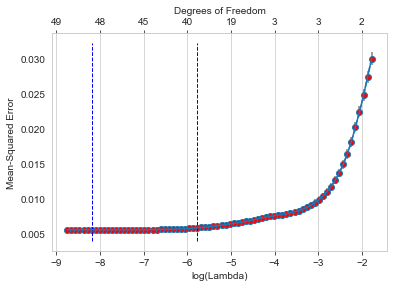

In [15]:
cvglmnetPlot(fit)


In [16]:
fit['lambda_min']


array([0.00027631])

In [17]:
fit['lambda_1se']


array([0.00310382])